In [1]:
import os
import geopandas as gpd
import rasterio
from shapely.geometry import box
import pyproj
import pandas as pd
from rasterio.features import dataset_features
import numpy as np
from tqdm import tqdm
import networkx as nx
import tempfile
import extra
import matplotlib.pyplot as plt
from functools import reduce

In [2]:
# Both of these files are available at https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/SYNPBS
# they're names are air_pollution_mortality.tab and counties.geojson
df = pd.read_csv("data/air_pollution_mortality_us/air_pollution_mortality.tab", 
                 sep="\t", 
                 index_col= "FIPS", 
                 dtype= {"FIPS": str})

df["Crude Rate"] = pd.to_numeric(df["Crude Rate"], errors='coerce')

gdf = gpd.read_file("data/air_pollution_mortality_us/counties.geojson")
geoid_col = next(col for col in gdf.columns if col in ["GEOID", "GEOID10", "GEOID20"])
gdf[geoid_col] = gdf[geoid_col].astype(str)

total_df = df.join(gdf.set_index(geoid_col), how="left")
total_gdf = gpd.GeoDataFrame(total_df, geometry="geometry")
total_gdf.head()

,qd_mean_pm25,cs_poverty,cs_hispanic,cs_black,cs_white,cs_native,cs_asian,cs_ed_below_highschool,cs_household_income,cs_median_house_value,...,Deaths,Population,Crude Rate,cdc_mortality_pct,bin_NORTHEAST,bin_SOUTH,bin_WEST,INTPTLAT10,INTPTLON10,geometry
FIPS,,,,,,,,,,,,,,,,,,,,,
01001,11.855572,0.085809,0.002805,0.132013,0.852475,0.008746,0.002640,0.253300,37351,133900.0,...,148.0,6546.0,2260.9,22.609227,0,1,0,32.536382,-86.644490,"POLYGON ((-86.62619 32.70638, -86.62498 32.706..."
01003,10.437929,0.053329,0.014039,0.051535,0.918627,0.005416,0.002242,0.160952,40104,177200.0,...,640.0,30568.0,2093.7,20.936928,0,1,0,30.659218,-87.746067,"POLYGON ((-87.61542 31.041, -87.61542 31.04073..."
01005,11.504243,0.194430,0.009459,0.333421,0.656069,0.000000,0.000000,0.405150,22143,88200.0,...,102.0,3909.0,2609.4,26.093630,0,1,0,31.870670,-85.405456,"POLYGON ((-85.62028 31.9455, -85.61987 31.9459..."
01007,11.886917,0.113087,0.001067,0.121977,0.866287,0.000000,0.000000,0.388691,24875,81200.0,...,73.0,2906.0,2512.0,25.120440,0,1,0,33.015893,-87.127148,"POLYGON ((-87.02561 33.17915, -87.02562 33.178..."
01009,11.659205,0.104793,0.009436,0.010554,0.968463,0.005836,0.000000,0.359449,25857,113700.0,...,202.0,8439.0,2393.6,23.936485,0,1,0,33.977448,-86.567246,"POLYGON ((-86.74361 33.83124, -86.74478 33.831..."


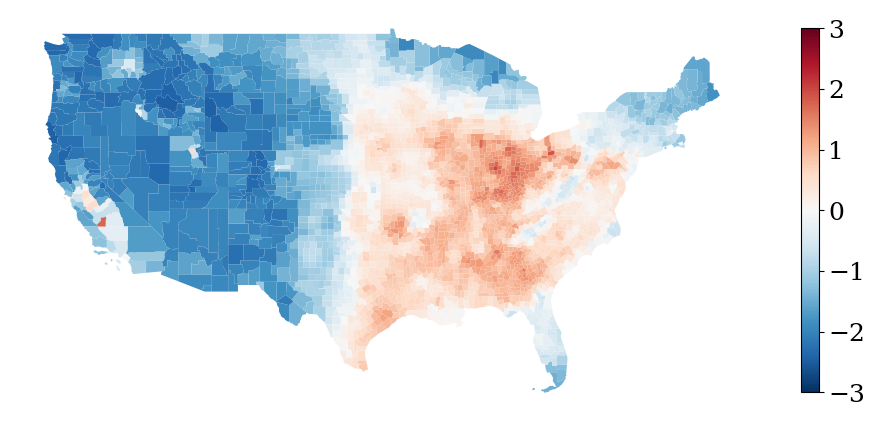

In [8]:
value = "qd_mean_pm25"
extra.show_maps_geo([value], total_gdf, standardize=True)
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = 18
plt.savefig(f"geo_{value}_map.pdf", bbox_inches='tight')
plt.show()

In [4]:
import warnings
warnings.filterwarnings("ignore", message="Geometry is in a geographic CRS.*centroid.*")

grid_df = {}
for val in df.columns:
    print(f"{val}...", end="")
    cur_gdf = total_gdf.copy()
    if val == "County":
        cur_gdf = extra.grid_gdf_quarter_degree_str(cur_gdf, val)
    else:
        cur_gdf = extra.grid_gdf_quarter_degree(cur_gdf, val)
    
    cur_gdf[['col', 'row']] = cur_gdf['grid_id'].str.extract(r'cell_(\d+)_(\d+)').astype(int)
    cur_gdf['row'] = cur_gdf['row'].max() - cur_gdf['row']
    cur_gdf = cur_gdf[["row", "col", val, "center_lat"]]
    if "bin" in val:
        cur_gdf[val] = np.where(cur_gdf[val].isna(), np.nan, (cur_gdf[val] > 0.5).astype(int))
    
    grid_df[val] = cur_gdf
    print(" done.")


qd_mean_pm25...

KeyboardInterrupt: 

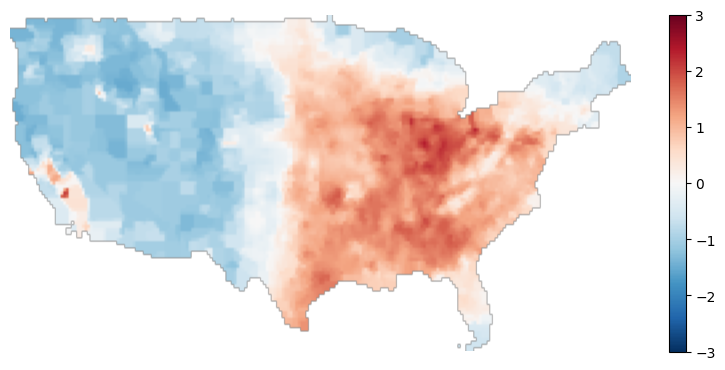

In [9]:
value = "qd_mean_pm25"
extra.show_maps_grid([value], grid_df[value], standardize=True)
# plt.savefig(f"grid_{value}_map.pdf", bbox_inches='tight')
plt.show()

In [19]:
def merge_dfs(df1, df2):
    merge_cols = ['row', 'col', 'center_lat']
    return df1.merge(df2, on=merge_cols, how='outer', suffixes=('', '_drop')).pipe(
        lambda x: x.drop(columns=[col for col in x.columns if col.endswith('_drop')])
    )

# Apply reduce to merge all DataFrames
final_df = reduce(merge_dfs, grid_df.values())
print("Final columns:", final_df.columns.tolist())

Final columns: ['row', 'col', 'qd_mean_pm25', 'center_lat', 'cs_poverty', 'cs_hispanic', 'cs_black', 'cs_white', 'cs_native', 'cs_asian', 'cs_ed_below_highschool', 'cs_household_income', 'cs_median_house_value', 'cs_other', 'cs_population_density', 'cdc_mean_bmi', 'cdc_pct_cusmoker', 'cdc_pct_sdsmoker', 'cdc_pct_fmsmoker', 'cdc_pct_nvsmoker', 'cdc_pct_nnsmoker', 'gmet_mean_tmmn', 'gmet_mean_summer_tmmn', 'gmet_mean_winter_tmmn', 'gmet_mean_tmmx', 'gmet_mean_summer_tmmx', 'gmet_mean_winter_tmmx', 'gmet_mean_rmn', 'gmet_mean_summer_rmn', 'gmet_mean_winter_rmn', 'gmet_mean_rmx', 'gmet_mean_summer_rmx', 'gmet_mean_winter_rmx', 'gmet_mean_sph', 'gmet_mean_summer_sph', 'gmet_mean_winter_sph', 'cms_mortality_pct', 'cms_white_pct', 'cms_black_pct', 'cms_others_pct', 'cms_hispanic_pct', 'cms_female_pct', 'County', 'Deaths', 'Population', 'Crude Rate', 'cdc_mortality_pct', 'bin_NORTHEAST', 'bin_SOUTH', 'bin_WEST']


In [20]:
print(len(final_df))
final_df = final_df.dropna(subset=['qd_mean_pm25'])
print(len(final_df))
final_df.index = pd.Index(final_df["row"].astype(str) + "_" + final_df["col"].astype(str))
final_df.head()

46833
14041


,row,col,qd_mean_pm25,center_lat,cs_poverty,cs_hispanic,cs_black,cs_white,cs_native,cs_asian,...,cms_hispanic_pct,cms_female_pct,County,Deaths,Population,Crude Rate,cdc_mortality_pct,bin_NORTHEAST,bin_SOUTH,bin_WEST
0_119,0,119,4.928787,49.375,0.050061,0.000000,0.000000,0.997558,0.00000,0.000000,...,0.000000,0.605263,"Lake of the Woods County, MN",17.0,821.0,NaN,20.706456,0.0,0.0,0.0
0_120,0,120,4.928787,49.375,0.050061,0.000000,0.000000,0.997558,0.00000,0.000000,...,0.000000,0.605263,"Lake of the Woods County, MN",17.0,821.0,NaN,20.706456,0.0,0.0,0.0
1_6,1,6,2.276833,49.125,0.070181,0.018827,0.002764,0.934906,0.01402,0.020149,...,0.009907,0.548297,"Whatcom County, WA",474.0,26640.0,NaN,17.792793,0.0,0.0,1.0
1_7,1,7,2.276833,49.125,0.070181,0.018827,0.002764,0.934906,0.01402,0.020149,...,0.009907,0.548297,"Whatcom County, WA",474.0,26640.0,NaN,17.792793,0.0,0.0,1.0
1_8,1,8,2.276833,49.125,0.070181,0.018827,0.002764,0.934906,0.01402,0.020149,...,0.009907,0.548297,"Whatcom County, WA",474.0,26640.0,NaN,17.792793,0.0,0.0,1.0


In [21]:
# make grid graph with diagonal connections
max_rows = final_df["row"].max()
max_cols = final_df["col"].max()
edgelist = []

for r in tqdm(range(max_rows + 1)):
    for c in range(max_cols + 1):
        # Horizontal edge (right)
        if c < max_cols:
            edgelist.append((f"{r}_{c}", f"{r}_{c+1}"))
        
        # Vertical edge (down)
        if r < max_rows:
            edgelist.append((f"{r}_{c}", f"{r+1}_{c}"))
        
        # Diagonal edges
        # Down-right diagonal
        if r < max_rows and c < max_cols:
            edgelist.append((f"{r}_{c}", f"{r+1}_{c+1}"))
        
        # Down-left diagonal
        if r < max_rows and c > 0:
            edgelist.append((f"{r}_{c}", f"{r+1}_{c-1}"))

G = nx.from_edgelist(edgelist)
G = nx.subgraph(G, final_df.index)
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

100%|██████████| 101/101 [00:00<00:00, 1633.65it/s]


Number of nodes: 14041
Number of edges: 55086


In [23]:
edges = pd.DataFrame(edgelist, columns=["source", "target"])
coords = final_df[["row", "col", "center_lat"]]

tmpdir = tempfile.TemporaryDirectory().name
os.makedirs(f"{tmpdir}/graph", exist_ok=True)
os.makedirs(f"uploads/dataverse", exist_ok=True)

edges.to_parquet(f"{tmpdir}/graph/edges.parquet")
coords.to_parquet(f"{tmpdir}/graph/coords.parquet")

os.system(f"cd {tmpdir} && tar -czvf graph_air_pollution_grid.tar.gz graph/edges.parquet graph/coords.parquet")
os.system(f"mv {tmpdir}/graph_air_pollution_grid.tar.gz uploads/dataverse/graph_air_pollution_grid.tar.gz")

# %%
final_df.drop(columns=["row", "col", "center_lat"]).to_parquet("uploads/dataverse/data_air_pollution_grid.parquet")

graph/edges.parquet
graph/coords.parquet
